AR composites of 250-hPa geopotential heights (contour lines), isotachs (contour shading), and wind vectors


## Imports

In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [4]:
plot_dict_non_anom = {'fname': 'ERA5/huvq/daily/out.era5_hma_05dg_daily_huvq_*.nc',
                      'clevs_wspd': np.arange(40,131,10),
                      'cmap_wspd': 'BuPu',
                      'clevs_hgts': np.arange(840,1280,12),
                      'quiver_scale': 10,
                      'quiver_key': 25,
                      'quiver_key_lbl': r'25 m s$^{-1}$',
                      'fig_name_prefix': 'ar_types_upper_'}

plot_dict_anom = {'fname': 'ERA5/huvq/anomalies/daily_filtered_anomalies_huvq_*.nc',
                  'clevs_wspd': np.arange(0,43,6),
                  'cmap_wspd': 'BuPu',
                  'clevs_hgts': np.arange(-10,11,2),
                  'quiver_scale': 2,
                  'quiver_key': 10,
                  'quiver_key_lbl': r'10 m s$^{-1}$',
                  'fig_name_prefix': 'anom_ar_types_upper_'}

plot_dict = plot_dict_non_anom

### ERA5 renalysis

In [5]:
# Select lat/lon grid
lonmin = 30
lonmax = 120
latmin = 0
latmax = 65

lev = 250.

def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=lev)

# # open HUV data
filepath_pattern = path_to_data + plot_dict['fname']   
    
f2 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')


# Create new dataset to rename lat lon
ds = xr.Dataset({'H': (['time', 'lat', 'lon'], f2['z'].values),
                 'U': (['time', 'lat', 'lon'], f2['u'].values),
                 'V': (['time', 'lat', 'lon'], f2['v'].values)},
                      coords={'time': (['time'], f2.time.values),
                              'lat': (['lat'], f2.latitude.values),
                              'lon': (['lon'], f2.longitude.values)})

ds
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))


ds size in GB 4.16



### AR days

In [6]:
fname_id = 'HUV500t0120050cor'
filepath = path_to_out + fname_id + 'hma_AR-types-djf.csv'
df = pd.read_csv(filepath)


In [7]:
# Trim date range
start_date = '1979-12-01'
end_date = '2018-02-28'
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Select DJF months
idx = (ds.time.dt.month >= 12) | (ds.time.dt.month <= 2)
ds = ds.sel(time=idx)

# Combine AR Cat data w/ reanalysis data
# Add ar time series to the ERA dataset
ds['ar'] = ('time', df.AR_CAT)
ds = ds.set_coords('ar')

In [8]:
def select_ar_days(era, lag=0):
    # Select only AR days
    idx = (era.ar >= 1)
    # select days with lag shift
    era_ar = era.shift(time=lag).sel(time=idx)
    # print results
    print(era_ar)
    
    return era_ar

In [9]:
# Lag=0, -2, +2
era_ar_lag0 = select_ar_days(era=ds, lag=0)
era_ar_lag2 = select_ar_days(era=ds, lag=-2)
era_ar_lead2 = select_ar_days(era=ds, lag=2)

<xarray.Dataset>
Dimensions:  (lat: 131, lon: 181, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 65.0 64.5 64.0 63.5 63.0 62.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 30.0 30.5 31.0 31.5 32.0 ... 118.5 119.0 119.5 120.0
    ar       (time) int64 3 3 1 3 3 2 3 3 3 2 1 3 3 ... 3 3 3 3 3 3 3 1 1 2 2 2
Data variables:
    H        (time, lat, lon) float32 95836.375 95796.67 ... 107387.73 107401.47
    U        (time, lat, lon) float32 24.491323 24.563282 ... -5.040886
    V        (time, lat, lon) float32 -14.716298 -14.968788 ... 2.9425917
<xarray.Dataset>
Dimensions:  (lat: 131, lon: 181, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 65.0 64.5 64.0 63.5 63.0 62.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 30.0 30.5 31.0 31.5 32.0 ... 118.5 119.0 119.5 120.0
    ar       (time) int64 3 3 1 3 3 2 3 3 3 2 1

### Compute AR Composites

In [10]:
# Compute composites of each AR type
era_ar_comp_lag0 = era_ar_lag0.groupby('ar').mean('time')
era_ar_comp_lag2 = era_ar_lag2.groupby('ar').mean('time')
era_ar_comp_lead2 = era_ar_lead2.groupby('ar').mean('time')

# combine lag datasets into 1 ds object
era_ar_comp = xr.concat([era_ar_comp_lead2, era_ar_comp_lag0, era_ar_comp_lag2], pd.Index([-2, 0, 2], name='lag'))
era_ar_comp

<xarray.Dataset>
Dimensions:  (ar: 3, lag: 3, lat: 131, lon: 181)
Coordinates:
  * lat      (lat) float32 65.0 64.5 64.0 63.5 63.0 62.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 30.0 30.5 31.0 31.5 32.0 ... 118.5 119.0 119.5 120.0
  * ar       (ar) int64 1 2 3
  * lag      (lag) int64 -2 0 2
Data variables:
    H        (lag, ar, lat, lon) float32 95980.34 95980.055 ... 107408.42
    U        (lag, ar, lat, lon) float32 14.569128 14.541887 ... -6.6661034
    V        (lag, ar, lat, lon) float32 -0.78091073 -0.71817964 ... 2.3100386

## Figure 6

### Common Plot Properties

In [11]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

### Create figure

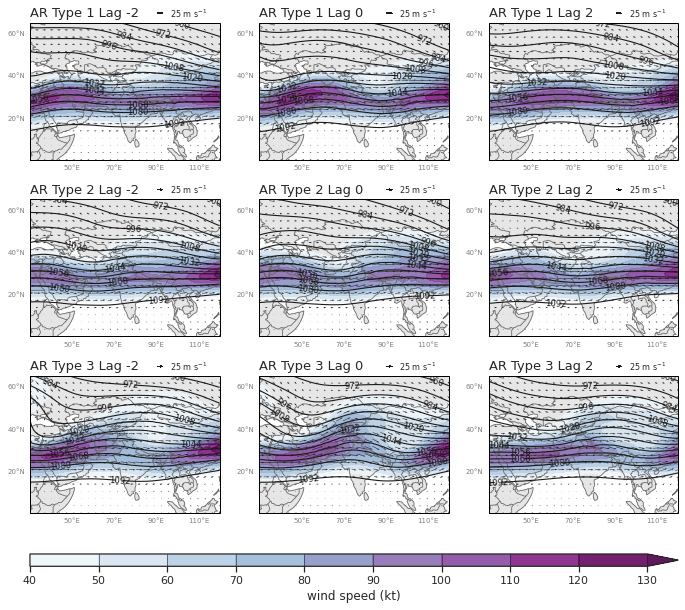

In [12]:
# Create figure
fig = plt.figure(figsize=(15,10))
nrows = 3
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.02, cbar_size='3%',label_mode='',
                direction='column')

# loop to draw plots
lag_lst = [-2, -2, -2, 0, 0, 0, 2, 2, 2]
artype_lst = [1, 2, 3, 1, 2, 3, 1, 2, 3]
for k, (ax, lag, ar_type) in enumerate(zip(axgr, lag_lst, artype_lst)):
    data = era_ar_comp.sel(lag=lag, ar=ar_type)
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    # Wind Speed (contour filled)
    clevs_wspd = plot_dict['clevs_wspd']
    # 250-hPa Winds (m/s)
    uwnd = data.U.values * units('m/s')
    vwnd = data.V.values * units('m/s')
    wspd = mpcalc.wind_speed(uwnd, vwnd)
    # 250-hPa Winds (knots)
    uwnd_kt = wspd.to('kt')
    vwnd_kt = wspd.to('kt')
    wspd_kt = wspd.to('kt')
    cf = ax.contourf(lons, lats, wspd_kt, transform=datacrs,
                     levels=clevs_wspd, cmap=plot_dict['cmap_wspd'], alpha=0.9, extend='max')
    
    # Geopotenital height lines
    clevs_hgts = plot_dict['clevs_hgts']
    # 250-hPa Heights
    hgts = data.H.values/(9.80665*10) # convert to geopotential height (m)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs_hgts, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)  
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uwnd, vwnd, transform=datacrs, 
             color='k', regrid_shape=20, pivot='middle',
              angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                      coordinates='axes', fontproperties={'size': 8.0})
   # subtitles
    plt_label = 'AR Type {0} Lag {1}'.format(ar_type, lag)
    ax.set_title(plt_label, loc='left',fontsize=13)
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
cb.set_label('wind speed (kt)')

# Save figure
filepath = path_to_figs + plot_dict['fig_name_prefix'] + fname_id + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()


### Composite EOF using Std Dev

In [ ]:
# 250-hPa Heights
hgts = era_eof_comp.H.values/9.80665 # convert to geopotential height

# 250-hPa Winds (m/s)
uwnd = era_eof_comp.U.values * units('m/s')
vwnd = era_eof_comp.V.values * units('m/s')
wspd = mpcalc.wind_speed(uwnd, vwnd)

# 250-hPa Winds (knots)
uwnd_kt = wspd.to('kt')
vwnd_kt = wspd.to('kt')
wspd_kt = wspd.to('kt')
print(wspd_kt.min(), wspd_kt.max())

plt_labels = ['AR EOF1', 'AR EOF2']

In [ ]:
 # Create figure
fig = plt.figure(figsize=(15,10))
nrows = 2
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.02, cbar_size='3%',label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Wind Speed (contour filled)
    clevs_wspd = np.arange(40,131,10)
    cf = ax.contourf(lons, lats, wspd_kt[k,:,:], transform=datacrs,
                     levels=clevs_wspd, cmap='BuPu', alpha=0.9)
    
    # Geopotenital height lines
    clevs_hgts = np.arange(840,1280,12)
    cs = ax.contour(lons, lats, hgts[k,:,:]/10., transform=datacrs,
                    levels=clevs_hgts, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)  
        
    # Wind barbs / vectors 
    ax.quiver(lons, lats, uwnd[k,:,:], vwnd[k,:,:], transform=datacrs, 
             color='k', regrid_shape=20, pivot='middle')
   # subtitles 
    ax.set_title(plt_labels[k], loc='left',fontsize=13)
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
cb.set_label('wind speed (kt)')

# Save figure
filepath = path_to_figs + 'eof_types_'+ fname_id + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
